### Import relevant libraries

In [1]:
import pathlib
import os
import datetime
import json

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
# %load_ext tensorboard

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv1D, concatenate
from tensorflow.keras.layers import ZeroPadding1D, Reshape, Input, Dropout, PReLU
from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.regularizers import L2

from sklearn.metrics import mean_absolute_error, r2_score

In [6]:
import prd_pipeline

In [7]:
import sys
sys.path.append('/mnt/batch/tasks/shared/LS_root/mounts/clusters/prd-ml/code/Users/hannah.brown/precip_rediagnosis/data_prep')
import drivers

In [8]:
# import mlflow
# mlflow.tensorflow.autolog()

### AzureML load - currently not working.

In [9]:
# azure_experiment_name='prd_frac_model_dev'
# azure_env_name = 'prd_ml_cluster'
# cluster_name = 'mlops-test'

In [10]:
# prd_model_name = 'azml_prd_frac_model_dev'

In [11]:
# events = [
#     '202002_storm_dennis', 
#     '202002_storm_ciara',
#     '202010_nswws_amber_oct',
#     '202012_nswws_amber_dec',
#     '202102_nswws_amber_feb',
#     '202110_nswws_amber_oct',
#     '202112_storm_barra',
#     '2022_storm_eunice_franklin',
#     '202008_storm_francis',
#     '202008_storm_ellen'
# ]

In [12]:
# data_dir = pathlib.Path('/project/informatics_lab/precip_rediagnosis') / 'storm_dennis_6hr_lt'

In [13]:
# azure_dataset_format = 'prd_merged_{event}'

In [14]:
# all_data = prd_pipeline.load_data(prd_ws, dataset_name=azure_dataset_format.format(event='all_events'))
# len(all_data.dropna().forecast_reference_time.unique())

In [15]:
# data_list = []
# for event in events:
#     print(azure_dataset_format.format(event=event))
#     tmpdat = prd_pipeline.load_data(prd_ws, dataset_name=azure_dataset_format.format(event=event))
#     data_list.append(tmpdat)
# merged_data = pd.concat(data_list)


In [16]:
# radar_type = 'radar_fraction_in_band_aggregate_3hr'
# for (band_name, band_vals) in new_bands.items():
#     cols_in_band = [col for col in data.columns for val in band_vals if (col.endswith(f'_{val}')) and (col.startswith(radar_type))]
#     data[band_name] = data[cols_in_band].sum(axis=1)

### Load and preprocess data

In [17]:
import azureml.core
from azureml.core import Workspace, Datastore, Dataset
from azureml.core import Experiment

prd_ws = Workspace.from_config()

In [18]:
configs_dir = pathlib.Path.cwd().parent / 'data_prep' / 'event_configs'
configs_dir.is_dir(), configs_dir

(True,
 PosixPath('/mnt/batch/tasks/shared/LS_root/mounts/clusters/prd-ml/code/Users/hannah.brown/precip_rediagnosis/data_prep/event_configs'))

In [19]:
config_path_list = [p1 for p1 in configs_dir.iterdir() if '20' in str(p1) and 'json' in str(p1)]

In [20]:
prd_merged_file_dataset_name = 'prd_merged_csv_files'
train202208_dataset_all = azureml.core.Dataset.get_by_name(prd_ws, name=prd_merged_file_dataset_name)
prd_prefix = 'prd'
merged_prefix = prd_prefix + '_merged'
csv_file_suffix = 'csv'

In [21]:
def get_file_name(dataset_config):

    event_start_dt = datetime.datetime.strptime(dataset_config['event_start'], '%Y-%m-%dT%H:%MZ')
    event_end_dt = datetime.datetime.strptime(dataset_config['event_end'], '%Y-%m-%dT%H:%MZ')
    times_list = drivers.calc_dates_list(event_start_dt, event_end_dt, float(dataset_config['target_time_delta']))
    final_timestamp = max(times_list)  # Data extract isn't inclusive of final date so need second last time 

    start_datestring = f'{event_start_dt.year:04d}{event_start_dt.month:02d}{event_start_dt.day:02d}T{event_start_dt.hour:02d}{event_start_dt.minute:02d}Z'
    end_datestring = f'{event_end_dt.year:04d}{event_end_dt.month:02d}{event_end_dt.day:02d}T{event_end_dt.hour:02d}{event_end_dt.minute:02d}Z'
    final_datestring = f'{final_timestamp.year:04d}{final_timestamp.month:02d}{final_timestamp.day:02d}T{final_timestamp.hour:02d}{final_timestamp.minute:02d}Z'
    
    # event_name = dataset_config["event_name"]
    
    return f'prd_merged_{start_datestring}_{final_datestring}.csv'

In [22]:
target_parameter = [
    'radar_fraction_in_band_instant_0.25', 
    'radar_fraction_in_band_instant_2.5',
    'radar_fraction_in_band_instant_7.0',
    'radar_fraction_in_band_instant_10.0'
]
profile_features = ['air_temperature', 'relative_humidity']#, 'cloud_volume_fraction', 'air_pressure']
single_lvl_features = []#['surface_altitude']#['thickness_of_rainfall_amount']#['air_pressure_at_sea_level'] 

In [23]:
feature_dict = {
    'profile': profile_features,
    'single_level': single_lvl_features,
    'target': target_parameter,
} 

In [24]:
# # merged_df_fname = f'prd_merged_{start_datestring}_{final_datestring}.csv'
# events_data_test = []
# events_data_train = []

# test_fraction = 0.2

# for config in config_path_list:
#     with open(config) as config_file:
#         dataset_config = json.load(config_file)

#     try: 
#         with train202208_dataset_all.mount() as train202208_file_mount:
#             selected_event_name = dataset_config['event_name']
#             print(f'\nload data for event {selected_event_name}\n')
#             merged_df_fname = get_file_name(dataset_config)
#             merged_df = pd.read_csv(pathlib.Path(train202208_file_mount.mount_point) / dataset_config['event_name'] / merged_df_fname)
#     except: 
#         pass

#     merged_df['time'] = pd.to_datetime(merged_df['time'])
#     merged_df['forecast_reference_time'] = pd.to_datetime(merged_df['forecast_reference_time'])
    
    
#     df_train, df_test = prd_pipeline.random_time_space_sample(merged_df, test_fraction=test_fraction, random_state=np.random.RandomState(), sampling_columns = ['time', 'latitude', 'longitude'])
#     events_data_test.append(df_test)
#     data_splits, data_dims_dict = prd_pipeline.preprocess_data(df_train, feature_dict, test_fraction=test_fraction/(1-test_fraction))

#     events_data_train.append(data_splits)

In [25]:
# data_test = pd.concat(events_data_test)
# data_test.to_csv('prd_merged_all_events_test_dataset.csv')

In [26]:
# data_splits = {
#     'X_train': np.concatenate([event['X_train'] for event in events_data_train]),
#     'X_val': np.concatenate([event['X_val'] for event in events_data_train]), 
#     'y_train': pd.concat([event['y_train'] for event in events_data_train]),
#     'y_val': pd.concat([event['y_val'] for event in events_data_train]),
# }

In [27]:
with train202208_dataset_all.mount() as train202208_file_mount:
    print('loading all data')
    prd_path_list = [p1 for p1 in pathlib.Path(train202208_file_mount.mount_point).rglob(f'{merged_prefix}*{csv_file_suffix}') ]
    merged_df = pd.concat([pd.read_csv(p1) for p1 in prd_path_list])

Not mounting as a volume: ArgumentError(InvalidArgument { argument: "arguments.path", expected: "Glob patterns inside the path are not supported by the volume mount.Path must be a direct path to the file or folder, or end with '/**' or '/**/*' to match the entire content of the volume.", actual: "REDACTED" }). 
Falling back to dataflow mount.
loading all data
Failure while loading azureml_run_type_providers. Failed to load entrypoint automl = azureml.train.automl.run:AutoMLRun._from_run_dto with exception (azureml-core 1.42.0.post1 (/anaconda/envs/azureml_py38/lib/python3.8/site-packages), Requirement.parse('azureml-core~=1.40.0')).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.PipelineRun = azureml.pipeline.core.run:PipelineRun._from_dto with exception (azureml-core 1.42.0.post1 (/anaconda/envs/azureml_py38/lib/python3.8/site-packages), Requirement.parse('azureml-core~=1.40.0')).
Failure while loading azureml_run_type_providers. Failed to load ent

In [28]:
# merged_df.dropna()

In [ ]:
test_fraction=0.2
df_train, df_test = prd_pipeline.random_time_space_sample(merged_df, test_fraction=test_fraction, random_state=np.random.RandomState(), sampling_columns = ['time', 'latitude', 'longitude'])
data_splits, data_dims_dict = prd_pipeline.preprocess_data(df_train, feature_dict, test_fraction=test_fraction/(1-test_fraction))

### Data pre-processing

In [27]:
# data_splits, data_dims_dict = prd_pipeline.preprocess_data(data, feature_dict, test_fraction=0.2, test_savefn='test.csv')

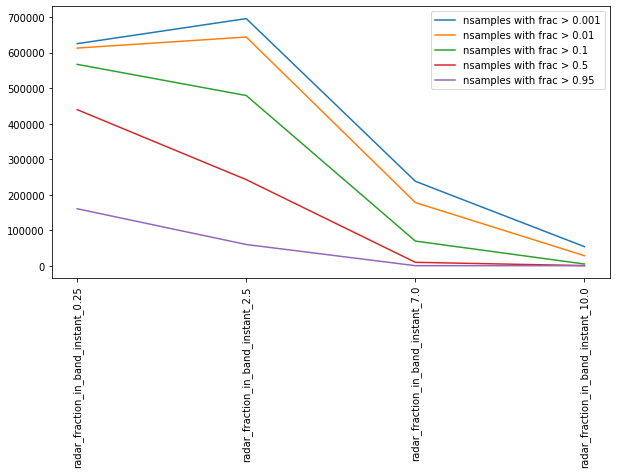

In [28]:
for frac in [0.001, 0.01, 0.1, 0.5, 0.95]:
    exceeding_prob = []
    for thresh in range(data_dims_dict['nbands']):
        exceeding_prob.append(sum(data_splits['y_train'].iloc[:, thresh] > frac))
    plt.plot(np.arange(data_dims_dict['nbands']), exceeding_prob, label=f'nsamples with frac > {frac}')
plt.xticks(np.arange(data_dims_dict['nbands']), data_splits['y_train'].columns, rotation=90)
plt.legend()
plt.gcf().set_size_inches(10, 5)
plt.show()

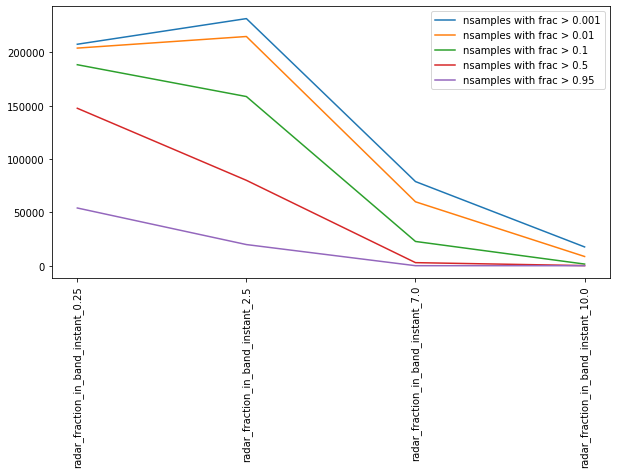

In [29]:
for prob in [0.001, 0.01, 0.1, 0.5, 0.95]:
    exceeding_prob = []
    for thresh in range(data_dims_dict['nbands']):
        exceeding_prob.append(sum(data_splits['y_val'].iloc[:, thresh] > prob))
    plt.plot(np.arange(data_dims_dict['nbands']), exceeding_prob, label=f'nsamples with frac > {prob}')
plt.xticks(np.arange(data_dims_dict['nbands']), data_splits['y_train'].columns, rotation=90)
plt.legend()
plt.gcf().set_size_inches(10, 5)
plt.show()

Resample data to create more uniform distribution within the training data

In [30]:
# data_splits['y_train']['max_bin'] = data_splits['y_train'].idxmax(axis=1)

# nsamples = len(data_splits['y_train'])//len(data_splits['y_train'].columns)

# y_train = pd.DataFrame()

# data_splits['y_train'] = data_splits['y_train'].reset_index(drop=True)
# for col in data_splits['y_train'].columns[0:-1]:
#     ids = data_splits['y_train'][data_splits['y_train']['max_bin']==col].index
#     if len(ids)>0:
#         choices = np.random.choice(ids, nsamples)
#         y_train = pd.concat([y_train, data_splits['y_train'].loc[choices]])
#         try: 
#             X_train = np.concatenate([X_train, data_splits['X_train'][choices]])
#         except NameError:
#             X_train = data_splits['X_train'][choices]

# cols = data_splits['y_train'].columns[:-1]
# plt.plot(data_splits['y_train'].sum(axis=0)[cols], label='original data')
# plt.plot(y_train.sum(axis=0)[cols], label='resampled data')
# plt.legend()
# plt.show()

# y_train = y_train.drop(columns=['max_bin'])

# data_splits['X_train'] = X_train
# data_splits['y_train'] = y_train
# data_dims_dict['nbands'] = data_splits['y_train'].shape[1]

## Set up model and experiment

In [31]:
def build_model(nprof_features, nheights, nsinglvl_features, nfractions=23):
    
    profile_input = Input(shape=(nheights, nprof_features), name='profile_input')
    prof_size = nheights*nprof_features

    out = ZeroPadding1D(padding=1)(profile_input)
    out = Conv1D(20, 5, strides=1, activation='relu')(out) #use_bias=False, bias_initializer='zeros'
    out = Dropout(0.8)(out)
    # ident = out
    # out = ZeroPadding1D(padding=1)(out)
    # out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, bias_initializer='zeros')(out)
    # out = ZeroPadding1D(padding=1)(out)
    # out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, kernel_initializer='glorot_uniform', bias_initializer='zeros')(out)
    # x = tf.keras.layers.add([out, ident])
    out = Flatten()(out)
    out = Dense(prof_size, activation='relu')(out) # use_bias=False,
    out = Dropout(0.5)(out)

#     if nsinglvl_features > 0:
#         surf_input = Input(shape=(nsinglvl_features,), name='surf_input')
#         flat_profs = Flatten()(profile_input)
#         raw_in = tf.keras.layers.concatenate([flat_profs, surf_input])
#         raw_size = (nheights*nprof_features)+nsinglvl_features

#         out = tf.keras.layers.concatenate([out, surf_input])
#         x = tf.keras.layers.add([out, raw_in])
#         x = Dense(1024, use_bias=False, activation='relu')(x)
#         x = Dense(1024, use_bias=False, activation='relu')(x)

#         main_output = Dense(23, use_bias=True, activation='softmax', name='main_output')(x)
#         model = Model(inputs=[profile_input, surf_input], outputs=[main_output])

#     else:
    main_output = Dense(nfractions, activation='softmax', name='main_output')(out) # use_bias=True, 
    model = Model(inputs=[profile_input], outputs=[main_output])
        
    return model

## Run experiment

Here we actually run the training and evaluation. All parameters and the output model will be saved through ML Flow, and we can track training stats through tensorboard.

In [32]:
def train_model(model, data_splits):
    # TODO: these hyperparameters should be read in from somewhere?
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
    # model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=optimizer)
    model.compile(loss=tf.keras.losses.KLDivergence(), optimizer=optimizer, metrics=['accuracy'],)
    # model.compile(loss='mean_absolute_error', optimizer=optimizer)

    history = model.fit(data_splits['X_train'], 
                        data_splits['y_train'], 
                        epochs=50, 
                        batch_size=100, 
                        validation_data=(data_splits['X_val'], data_splits['y_val']),  verbose=True)
    return model, history

In [33]:
# exp = mlflow.create_experiment('prd_frac_experiment')

In [35]:
# exp1 = mlflow.get_experiment('2')
# exp1

In [36]:
hyperparameter_dict = {
    'loss_function': tf.keras.losses.KLDivergence(),
    'epochs': 20, 
    'learning_rate': 0.001, 
    'batch_size': 500
}

In [38]:
# with mlflow.start_run(experiment_id=exp1.experiment_id, run_name='new data - all members zeros included resampled') as current_run:
#     mlflow.log_param('features', feature_dict['profile'] + feature_dict['single_level'])    
model = prd_pipeline.build_model(**data_dims_dict)
model.summary()
model = prd_pipeline.train_model(model, data_splits, hyperparameter_dict)
    
#     model = build_model(data_dims_dict['nprof_features'], data_dims_dict['nheights'], data_dims_dict['nsinglvl_features'], data_dims_dict['nbands'])
#     model.summary()
#     model, history = train_model(model, data_splits)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
profile_input (InputLayer)      [(None, 33, 2)]      0                                            
__________________________________________________________________________________________________
zero_padding1d (ZeroPadding1D)  (None, 35, 2)        0           profile_input[0][0]              
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 33, 32)       192         zero_padding1d[0][0]             
__________________________________________________________________________________________________
zero_padding1d_1 (ZeroPadding1D (None, 35, 32)       0           conv1d[0][0]                     
______________________________________________________________________________________________

In [39]:
plt.plot(range(50), history.history['val_loss'])
plt.plot(range(50), history.history['loss'])

NameError: name 'history' is not defined

In [ ]:
plt.plot(range(50), history.history['val_accuracy'])
plt.plot(range(50), history.history['accuracy'])

In [ ]:
y_pred = model.predict(data_splits['X_val'])
# error = mean_absolute_error(data_splits['y_val'], y_pred)
# print(f'MAE: {error:.3f}')
# rsqrd = r2_score(data_splits['y_val'],, y_pred)
# print(f'R-squared score: {rsqrd:.3f}')


# fig1 = plt.figure(figsize=(10, 8))
# ax1 = fig1.add_subplot(1,1,1, title='Actual vs #predicted 3hr rainfall accumulations.')
# ax1.scatter(y_test, y_pred, s=200, c='darkblue')
# ax1.plot([0, 300], [0, 300], ls="--", c=".3")
# ax1.set_xlabel('Actual 3hr precip accumulation value')
# ax1.set_ylabel('Predicted 3hr precip_accumulation value')

# fig1 = plt.figure(figsize=(10, 8))
# ax1 = fig1.add_subplot(1,1,1, title='Historgram of Actual vs predicted 3hr rainfall accumulations.')
# ax1.hist(y_test, alpha=0.5, bins=40, label='Actual')
# ax1.hist(y_pred, alpha=0.5, bins=40, label='Predicted')
# ax1.legend()  

In [ ]:
# plt.plot(y_pred[0] - data_splits['y_val'].iloc[0])

In [ ]:
for loc in range(30):
    plt.plot(y_pred[loc], label='prediction')
    plt.plot(data_splits['y_val'].iloc[loc], label='target')
    plt.legend()
    plt.show()

In [ ]:
for prob in [0.001, 0.01, 0.1, 0.5, 0.95]:
    exceeding_prob = []
    for thresh in range(4):
        exceeding_prob.append(sum(data_splits['y_train'].iloc[:, thresh] > prob))
    plt.plot(np.arange(4), exceeding_prob, label=f'nsamples with frac > {prob}')
plt.xticks(np.arange(4), data_splits['y_train'].columns, rotation=90)
plt.legend()
plt.gcf().set_size_inches(10, 5)
plt.show()

In [ ]:
for prob in [0.000001, 0.001, 0.01, 0.1, 0.5, 0.95]:
    exceeding_prob = []
    for thresh in range(4):
        exceeding_prob.append(sum(data_splits['y_val'].iloc[:, thresh] > prob))
    plt.plot(np.arange(4), exceeding_prob, label=f'nsamples with frac > {prob}')
plt.xticks(np.arange(4), data_splits['y_train'].columns, rotation=90)
plt.legend()
plt.gcf().set_size_inches(10, 5)
plt.show()

In [ ]:
for prob in [0.000001, 0.001, 0.01, 0.1, 0.5, 0.95]:
    exceeding_prob = []
    for thresh in range(4):
        exceeding_prob.append(sum(y_pred[:, thresh] > prob))
    plt.plot(np.arange(4), exceeding_prob, label=f'nsamples with frac > {prob}')
plt.xticks(np.arange(4), data_splits['y_train'].columns, rotation=90)
plt.legend()
plt.gcf().set_size_inches(10, 5)
plt.show()

In [ ]:
# for prob in [ 0.001, 0.01, 0.1, 0.5, 0.75, 0.95]:
#     exceeding_prob_val = []
#     exceeding_prob_pred = []
#     for thresh in range(23):
#         exceeding_prob_val.append(sum(data_splits['y_val'].iloc[:, thresh] > prob))
#         exceeding_prob_pred.append(sum(y_pred[:, thresh] > prob))
#     plt.plot(np.arange(23), exceeding_prob_val, label=f'actual vals')
#     plt.plot(np.arange(23), exceeding_prob_pred, label=f'predicted vals')
#     plt.title(f'nsamples with frac > {prob}')
#     plt.xticks(np.arange(23), data_splits['y_train'].columns, rotation=90)
#     plt.legend()
#     plt.gcf().set_size_inches(10, 5)
#     plt.show()

In [ ]:
data_splits['y_train'].iloc[:, thresh]

In [ ]:
for thresh in range(4): 
    bins=np.linspace(0,1,51)
    # plt.hist(y_pred[:, thresh], alpha=0.5, label='pred', bins=bins, log=True)#,stacked=True, density=True
    # plt.hist(data_splits['y_val'].iloc[:, thresh], alpha=0.5, label=f'val {thresh}', bins=bins,log=True, ) # stacked=True, density=True
    plt.hist(data_splits['y_train'].iloc[:, thresh], alpha=0.5, label=f'train {thresh}', bins=bins, log=True)#  stacked=True, density=True
    plt.legend()
    plt.show()

In [ ]:
for thresh in range(4): 
    bins=np.linspace(0,1,51)
    plt.hist(y_pred[:, thresh], alpha=0.5, label='pred', bins=bins, log=True)#,stacked=True, density=True
    plt.hist(data_splits['y_val'].iloc[:, thresh], alpha=0.5, label=f'val {thresh}', bins=bins,log=True, ) # stacked=True, density=True
    # plt.hist(data_splits['y_train'].iloc[:, thresh], alpha=0.5, label=f'train {thresh}', bins=bins, histtype='step', log=True)#  stacked=True, density=True
    plt.legend()
    plt.show()
    
#     error = mean_absolute_error(data_splits['y_val'].iloc[:, thresh], y_pred[:, thresh])
#     print(f'MAE: {error:.3f}')
#     rsqrd = r2_score(data_splits['y_val'].iloc[:, thresh], y_pred[:, thresh])
#     print(f'R-squared score: {rsqrd:.3f}')
    